#**Installation and Imports**

In [3]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 14.7 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 3.5 MB 13.0 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 2.3 MB 12.8 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 747 kB 14.1 MB/s 
     |████████████████████████████████| 370 kB 14.8 MB/s 
     |████████████████████████████████| 482 kB 52.1 MB/s 
     |████████████████████████████████| 41 kB 467 kB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.3-py3-none-any.whl size=581969 sha256=66d6639a0911db623b53bb70b74002955615183c95d7beaecc2d9d9987703266
  Stored in directory: /root/.cache/pip/wheels/c3/2a/58/87ce0508964d4def1aafb92750c4f3ac77038efd1b9a89dcf5
Successfully bui

In [4]:
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
from torch_geometric.utils import to_networkx, from_networkx
from torch_geometric.nn import Node2Vec
import torch.nn as nn
import torch_cluster
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GNNExplainer

import networkx as nx

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

import numpy as np
import pandas as pd

from typing import Callable

from tqdm.notebook import tqdm
import time

import os

from pylab import rcParams

from google.colab.patches import cv2_imshow
import cv2

import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#reproducing same results (report results are given for the current seed)
SEED = 123

#torch
torch.manual_seed(SEED)

#cuda algorithms
torch.backends.cudnn.deterministic = True 

#numpy
np.random.seed(SEED)

In [7]:
#defined once for all
device = torch.device(
    'cuda' if torch.cuda.is_available() 
     else 'cpu'
    )
print(device)

cpu


In [8]:
#replace with your path
path = '/content/drive/MyDrive/dm_hw4_data/'

# **Data Inspection and Preparation**

## **Datasets**

In [9]:
#import gda dataset
with open(os.path.join(path, 'all_gene_disease_associations.tsv'),'r') as f:
    gda = pd.read_csv(f, delimiter = '\t')

In [10]:
print(gda.shape)
gda.head()

(1134942, 16)


,geneId,geneSymbol,DSI,DPI,diseaseId,diseaseName,diseaseType,diseaseClass,diseaseSemanticType,score,EI,YearInitial,YearFinal,NofPmids,NofSnps,source
0,1,A1BG,0.7,0.538,C0001418,Adenocarcinoma,group,C04,Neoplastic Process,0.01,1.0,2008.0,2008.0,1,0,LHGDN
1,1,A1BG,0.7,0.538,C0002736,Amyotrophic Lateral Sclerosis,disease,C18;C10,Disease or Syndrome,0.01,1.0,2008.0,2008.0,1,0,BEFREE
2,1,A1BG,0.7,0.538,C0003578,Apnea,phenotype,C23;C08,Sign or Symptom,0.01,1.0,2017.0,2017.0,1,0,BEFREE
3,1,A1BG,0.7,0.538,C0003864,Arthritis,disease,C05,Disease or Syndrome,0.01,1.0,2019.0,2019.0,1,0,BEFREE
4,1,A1BG,0.7,0.538,C0008373,Cholesteatoma,disease,C17,Disease or Syndrome,0.01,1.0,2020.0,2020.0,1,0,BEFREE


In [11]:
#import ppi dataset
with open(os.path.join(path, 'Biogrid_4.4.199_Hs.txt'),'r') as f:
    ppi = pd.read_csv(f, delimiter = ' ', header = None)

In [12]:
ppi.head()

,0,1
0,MAP2K4,FLNC
1,MYPN,ACTN2
2,ACVR1,FNTA
3,GATA2,PML
4,RPA2,STAT3


In [13]:
#take top 10000 interactions from the dataset
ppi_reduced = ppi.head(10000)
ppi_reduced.shape

(10000, 2)

In [14]:
#set operation deletes duplicates
unique_gene_names = list(set(ppi_reduced[0]).union(set(ppi_reduced[1])))
len(unique_gene_names)

4263

In [15]:
#iterate over gene names in gda and check if names falls into desired list
gda_filtered = gda[gda['geneSymbol'].isin(unique_gene_names)]
print(gda_filtered.shape)

(378594, 16)


In [16]:
#group by the disease name, count number of associated genes sort and take the top value
disease_of_interest_id = gda_filtered.groupby(['diseaseId'])['geneId'].count().sort_values(ascending=False).head(1).index[0]
disease_of_interest_id

'C0027651'

In [17]:
#take only gene names from gda which corrrspond to the id of the chosen disease
gda_reduced = gda_filtered[gda_filtered['diseaseId']==disease_of_interest_id][['geneSymbol']]
print(gda_reduced.shape)
gda_reduced.head()

(2621, 1)


,geneSymbol
79,A2M
697,SERPINA3
1335,ABCA1
2069,ABL1
2432,ABL2


## **Graph**

### **Networkx Graph**

In [18]:
#indexed vocabulary gene name -> index
word_index = dict()

for index, word, in enumerate(unique_gene_names):
  word_index[word] = index

In [19]:
#take all indices from vocabulary and convert into tensor input
x = torch.tensor(list(word_index.values()), dtype = torch.float)
x

tensor([0.0000e+00, 1.0000e+00, 2.0000e+00,  ..., 4.2600e+03, 4.2610e+03,
        4.2620e+03])

In [20]:
#creates tensor of 0/1 values, where gene indices associated with disease are mapped to 1
y = torch.tensor([1 if gene_name in list(gda_reduced['geneSymbol']) else 0 
                  for gene_name in list(word_index.keys())], dtype = torch.float)
y

tensor([1., 1., 1.,  ..., 0., 0., 1.])

In [21]:
#fulfills two lists iterating over PPI data
gene1_l = []
gene2_l = []
for gene1, gene2 in ppi_reduced.values:
  gene1_l.append(word_index[gene1])
  gene2_l.append(word_index[gene2])

In [22]:
#lists are stacked into a single tensor
edge_index = torch.stack((torch.tensor(gene1_l, dtype=torch.long),torch.tensor(gene2_l, dtype=torch.long)))
edge_index

tensor([[ 530, 1362, 2956,  ..., 3156, 4239, 4239],
        [ 989, 1905, 3469,  ...,  753, 3818, 3567]])

In [23]:
#data object
data = Data(x = x, y = y, edge_index = edge_index)

In [24]:
data

Data(x=[4263], edge_index=[2, 10000], y=[4263])

In [25]:
#form Networkx graph as undirected and with self-loops removal
G = to_networkx(data, to_undirected = True, remove_self_loops = True)
print("Graph G with {} nodes and {} edges has been constructed.".format(G.number_of_nodes(), G.number_of_edges()))

Graph G with 4263 nodes and 4290 edges has been constructed.


Graph visualization with Networkx took 78.8665177822113 seconds.



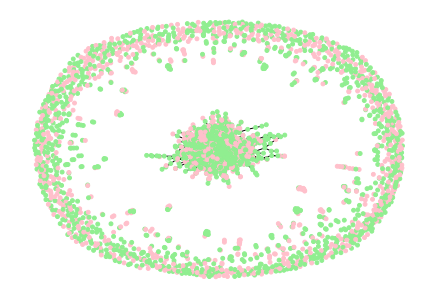

In [26]:
#drawing of the full graph with Networkx
start_time = time.time()
colors = [['pink', 'lightgreen'][list(word_index.keys())[list(word_index.values()).index(node)]
                                          in list(gda_reduced['geneSymbol'])] for node in G.nodes()]
nx.draw_spring(G, node_size = 15, node_color = colors)
plt.savefig("graph.png", format = "PNG")
print("Graph visualization with Networkx took {} seconds.\n".format(time.time() - start_time))

### **Cytoscape**

In [27]:
#save the graph to be imported to the Cytoscape
nx.write_graphml(G,'g.xml')

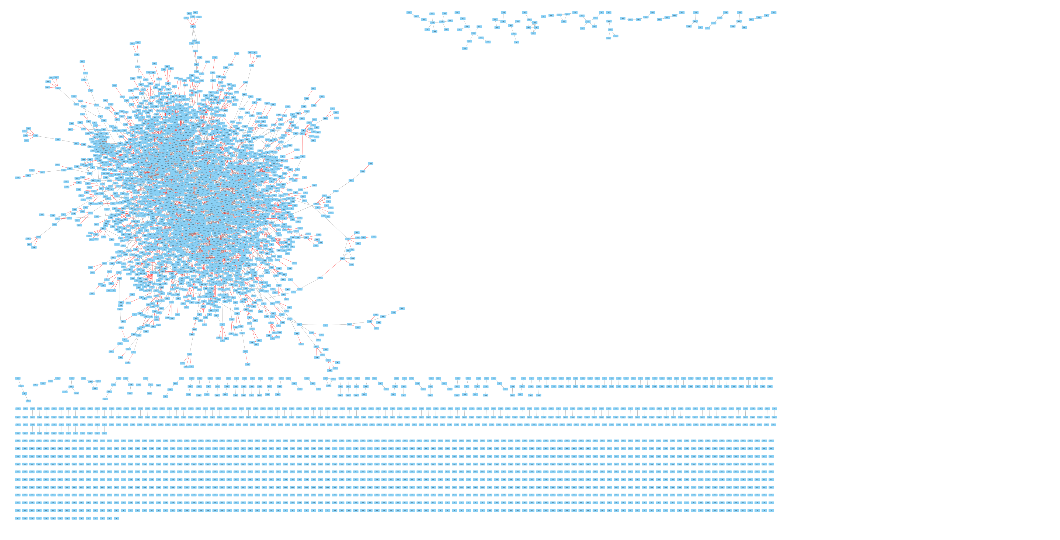

In [28]:
#print out the screenshoted Cytoscape interface for the full graph representation
demo_graph = cv2.imread(os.path.join(path, 'demo_graph.png'))
demo_graph_r = cv2.resize(demo_graph, (1060, 540))  
cv2_imshow(demo_graph_r)

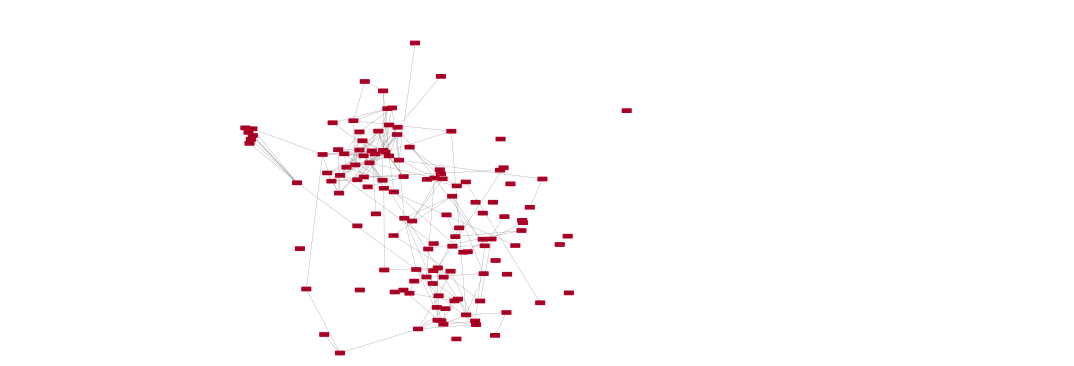

In [29]:
#print out the selected Cytoscape sungraph of nodes with degree higher than 10
demo_subgraph = cv2.imread(os.path.join(path, 'demo_subgraph.png'))
cv2_imshow(demo_subgraph)

In [30]:
#import the table build by Cytoscape in correspondence with the afrementioned subgraph
with open(os.path.join(path, 'large_degree_nodes.csv'),'r') as f:
    large_degree_nodes = pd.read_csv(f, delimiter = ',')
large_degree_nodes.head()

,diffusion_input,diffusion_output_heat,diffusion_output_rank,name,selected,shared name
0,1.0,1.0,0,2867,False,2867
1,1.0,1.0,1,333,False,333
2,1.0,1.0,2,3677,False,3677
3,1.0,1.0,3,2593,False,2593
4,1.0,1.0,4,3336,False,3336


### **Subgraph Extraction**

Extracted **subgraph will be a lot smaller** than the one on the screenshot of the Cytoscape due to the undirectionality and self-loops and isolated nodes removal.


Subgraph Data (including isolated nodes):

 Data(x=[127], edge_index=[2, 16], y=[127])


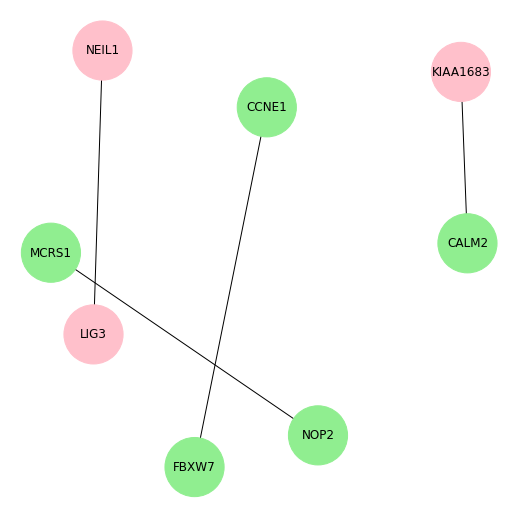

In [31]:
#custom utilities for the subgraph extraction and plotting
#NOTE: not all stochastic components are eliminated => through the reset of the environment different graphs will be obtained
np.random.seed(SEED)
torch.manual_seed(SEED)

#filters gene name to index dictionary leaving only the nodes of interest (i.e. nodes belonging to the subgraph)
#then creates Networkx graph through the same sequence of steps as before
def extract_subgraph(selected_nodes, full_dict, remove_isolated = True):

    subdict = dict()

    for (key, value) in full_dict.items():
      if value in selected_nodes:
          subdict[key] = value

    x = torch.tensor(list(subdict.values()), dtype = torch.float)

    y = torch.tensor([1 if gene_name in list(gda_reduced['geneSymbol']) else 0 
                  for gene_name in list(subdict.keys())], dtype = torch.float)
    
    gene1_l = []
    gene2_l = []
    for gene1, gene2 in ppi_reduced.values:
      if (gene1 in list(subdict.keys())) and (gene2 in list(subdict.keys())):
        gene1_l.append(subdict[gene1])
        gene2_l.append(subdict[gene2])

    edge_index = torch.stack((torch.tensor(gene1_l, dtype=torch.long),torch.tensor(gene2_l, dtype=torch.long)))

    data = Data(x = x, y =y, edge_index = edge_index)
    print("\nSubgraph Data (including isolated nodes):\n\n", data)

    G = to_networkx(data, to_undirected = True, remove_self_loops = True)

    if remove_isolated:
      G.remove_nodes_from(list(nx.isolates(G)))

    return G, subdict

#lates the nodes of subgraph can be explained with GNNExplainer
sG, subdict = extract_subgraph(large_degree_nodes['name'].values, word_index, remove_isolated = True)

#sets up and applies nx.draw for the just created graph
def plot_subgraph(sG, subdict,
                  figsize_w, figsize_h,
                  k_factor,
                  color_list,
                  node_size_factor):    
    
    rcParams['figure.figsize'] = figsize_w, figsize_h

    pos = nx.spring_layout(sG, k = k_factor / np.sqrt(sG.order()), seed = SEED)

    labeldict = {}
    for node in sG.nodes():
        labeldict[node] = list(subdict.keys())[list(subdict.values()).index(node)]

    colors = [color_list[list(subdict.keys())[list(subdict.values()).index(node)]
                                          in list(gda_reduced['geneSymbol'])] for node in sG.nodes()]

    degree = dict(sG.degree())

    nx.draw(sG, 
            pos, 
            labels = labeldict, 
            with_labels = True, 
            nodelist = degree, 
            node_size = [degree[key] * node_size_factor for key in degree], 
            node_color = colors)
    
    plt.savefig("subgraph.png", format = "PNG")

#other drawing parameters could be used 
plot_subgraph(sG, subdict, 7, 7, 5, ['pink', 'lightgreen'], 3500)

## **Feature Vectors**

In [32]:
#standard scaler is needed, because due to the graph properties 'normalized = True' is not enough to achieve values between 0 and 1
scale = StandardScaler()
def make_feature(G, mode='degree'):

  if mode == 'degree':
    feature = nx.degree_centrality(G)
  elif mode == 'betweenness':
    feature = nx.betweenness_centrality(G, normalized = True)
  elif mode == 'load':
    feature = nx.load_centrality(G, normalized = True)
  elif mode == 'eigenvector':
    feature = nx.eigenvector_centrality(G, max_iter = 1000)
  else:
    feature = nx.closeness_centrality(G)

  #np.array(list(feature.values())).sum()

  feature = np.array(list(feature.values()))
  feature = scale.fit_transform(feature.reshape(-1, 1))
  feature = torch.from_numpy(feature).type(torch.float32).squeeze(1)

  return feature

In [33]:
#execution for the PPI reduced takes around 2.5 mins
#the longest computation time corresponds to the betweenness_centrality
start_time = time.time()
feature_vectors = torch.stack((make_feature(G, 'degree'), 
                               make_feature(G, 'betweenness'), 
                               make_feature(G, 'load'), 
                               make_feature(G, 'eigenvector'), 
                               make_feature(G, 'closeness')), dim = 1)
print('Computation of the feature vectors took {} seconds.\n'.format(time.time() - start_time))
print('The obtained feature matrix is:\n\n', feature_vectors)

Computation of the feature vectors took 89.96654939651489 seconds.

The obtained feature matrix is:

 tensor([[-0.2722, -0.2511, -0.2558, -0.0931, -1.1467],
        [-0.2722, -0.2511, -0.2558, -0.0916,  0.8807],
        [-0.2722, -0.2511, -0.2558, -0.0931, -1.1467],
        ...,
        [-0.2722, -0.2511, -0.2558, -0.0909,  0.5714],
        [-0.5409, -0.2511, -0.2558, -0.0931, -1.1515],
        [ 0.5341,  0.3405,  0.3652, -0.0926,  0.8418]])


In [34]:
#dataset class for the input to Node2Vec and GCN models (could be applied to any other if desired)
#creates split into train and test using masks
class InputDataset(InMemoryDataset):

    def __init__(self, 
                 x: torch.Tensor, 
                 y: torch.Tensor, 
                 edge_index: torch.Tensor,
                 G: nx.classes.graph.Graph,
                 embedding_dim = 128,
                 test_size = 0.3, 
                 transform = None):
      super(InputDataset, self).__init__(".", transform, None, None)

      data = Data(edge_index = edge_index)

      data.x = x

      labels = y.type(torch.long)

      data.y = labels.clone().detach()

      data.num_nodes = G.number_of_nodes()

      data.embedding_dim = embedding_dim

      X_train, X_test, y_train, y_test = train_test_split(pd.Series(G.nodes()), 
                                                          pd.Series(y.numpy()), 
                                                          test_size = test_size, 
                                                          random_state = SEED)
      
      train_mask = torch.zeros(data.num_nodes, dtype = torch.bool)
      test_mask = torch.zeros(data.num_nodes, dtype = torch.bool)

      train_mask[X_train.index] = True
      test_mask[X_test.index] = True

      data['train_mask'] = train_mask
      data['test_mask'] = test_mask

      self.data, self.slices = self.collate([data])

In [35]:
input_dataset = InputDataset(feature_vectors, 
                             y, 
                             edge_index, 
                             G)

In [36]:
input_data = input_dataset[0]
print(input_data)

print("\nX_train: ", input_data.x[input_data['train_mask']].shape)
print("y_train: ", input_data.y[input_data['train_mask']].shape)

print("\nX_test: ", input_data.x[input_data['test_mask']].shape)
print("y_test: ", input_data.y[input_data['test_mask']].shape)

Data(edge_index=[2, 10000], x=[4263, 5], y=[4263], num_nodes=4263, embedding_dim=128, train_mask=[4263], test_mask=[4263])

X_train:  torch.Size([2984, 5])
y_train:  torch.Size([2984])

X_test:  torch.Size([1279, 5])
y_test:  torch.Size([1279])


#**Models**

## **Approach 1 (Node2Vec Embedding)**

### **Node2Vec (N2V)**

In [37]:
#implements custom train method adapted for the Node2Vec inported from the torch_geometric.nn
#uses loader iterating over positive and negative random walks
#monitors and accumulates training loss
class N2VTrainer():

    def __init__(self, 
                 model: torch_geometric.nn.models.node2vec.Node2Vec,
                 optimizer: torch.optim,
                 device = 'cpu',
                 epochs = 100):
      super(N2VTrainer, self).__init__()
      
      self.device = device
      self.model = model
      self.optimizer = optimizer
      self.epochs = epochs

    def train(self,
              loader: torch.utils.data.dataloader.DataLoader,
              verbose = True):
      
      train_loss = []

      for epoch in tqdm(range(1, self.epochs + 1)):

          self.model.train()

          epoch_loss = 0

          for pos_rw, neg_rw in loader:

              pos_rw = pos_rw.to(self.device)
              neg_rw = neg_rw.to(self.device)

              self.optimizer.zero_grad()

              loss = self.model.loss(pos_rw, neg_rw)

              loss.backward()

              self.optimizer.step()

              epoch_loss += loss.item()

          train_loss.append(epoch_loss / len(loader))

          if (verbose and epoch % 10 == 0) or (epoch == self.epochs):

              print(f'  Epoch {epoch:3d} => Loss: {epoch_loss / len(loader)}')

      return {
          'train_history': train_loss
          }

**Dashboard** to control model training and all the pipeline of Node2Vec training.

Currently set up hyperparameters correspond to the reported ones.

In [38]:
torch.manual_seed(SEED)

#@title Node2Vec Hyperparameters 

class N2VHparams():
  #@markdown Dataset
  test_size = 0.2 #@param {type: "slider", min:0.1, max:0.5, step:0.1}
  embedding_dim = 64 #@param {type:"number"}
  #@markdown Model
  walk_length = 20 #@param {type:"slider", min:10, max:100, step:10}
  context_size = 10 #@param {type:"integer"}
  walks_per_node = 10 #@param {type:"integer"}
  num_negative_samples = 1 #@param {type:"integer"}
  p = 0.5 #@param {type:"slider", min:0, max:2, step:0.1}
  q = 2 #@param {type:"slider", min:0, max:2, step:0.1}
  #@markdown Loader
  batch_size = 128 #@param {type:"integer"}
  num_workers = 2 #@param {type:"slider", min:1, max:4, step:1}
  #@markdown Optimizer
  lr = 0.01 #@param {type:"number"}
  #@markdown Trainer
  epochs = 100 #@param {type:"slider", min:100, max:1000, step:100}
  
n2v_hparams = N2VHparams()

n2v_input_dataset = InputDataset(
    feature_vectors, 
    y, 
    edge_index, 
    G, 
    n2v_hparams.embedding_dim, 
    n2v_hparams.test_size
    )

n2v_input_data = n2v_input_dataset[0]
n2v_input_data = n2v_input_data.to(device)


n2v = Node2Vec(
    n2v_input_data.edge_index, 
    embedding_dim = n2v_hparams.embedding_dim, 
    walk_length = n2v_hparams.walk_length,
    context_size = n2v_hparams.context_size, 
    walks_per_node = n2v_hparams.walks_per_node,
    num_negative_samples = n2v_hparams.num_negative_samples,
    p = n2v_hparams.p,
    q = n2v_hparams.q,
    sparse = True
    ).to(device)

n2v_loader = n2v.loader(
    batch_size = n2v_hparams.batch_size, 
    shuffle = True, 
    num_workers = n2v_hparams.num_workers)

n2v_optimizer = torch.optim.SparseAdam(
    list(n2v.parameters()), 
    lr = n2v_hparams.lr)

n2v_trainer = N2VTrainer(
    n2v,
    n2v_optimizer,
    device,
    epochs = n2v_hparams.epochs
)

#set verbose = False, if don't want to monitor loss
n2v_train_loss = n2v_trainer.train(
    n2v_loader,
    verbose = True
)

  0%|          | 0/100 [00:00<?, ?it/s]

  Epoch  10 => Loss: 0.846502645927317
  Epoch  20 => Loss: 0.757118878995671
  Epoch  30 => Loss: 0.7431391249684727
  Epoch  40 => Loss: 0.7392856355975655
  Epoch  50 => Loss: 0.7377918678171494
  Epoch  60 => Loss: 0.7373626091900993
  Epoch  70 => Loss: 0.7371798192753511
  Epoch  80 => Loss: 0.7365253900780397
  Epoch  90 => Loss: 0.7370471253114588
  Epoch 100 => Loss: 0.7369322987163768


In [39]:
#simple utility for testing: computes only accuracy metrics
@torch.no_grad()
def n2v_test(model, input_data, max_iter = 100):

    model.eval()

    z = model()

    test_acc = model.test(z[input_data.train_mask], input_data.y[input_data.train_mask],
                          z[input_data.test_mask], input_data.y[input_data.test_mask],
                          max_iter = max_iter)
    
    return {
        'test_accuracy': test_acc
        }

n2v_test_acc = n2v_test(
    n2v,
    n2v_input_data,
    100)
print("Node2Vec Test acc: ", n2v_test_acc['test_accuracy'])

Node2Vec Test acc:  0.5885111371629543


In [40]:
#print latent vectors: learnt embeddings
z = n2v()
embedding = z.detach().cpu().numpy()
print('Node embedding shape: ', embedding.shape)
print('\nNode embedding: ')
print(embedding)

Node embedding shape:  (4263, 64)

Node embedding: 
[[-0.0812532   0.24991445  0.05669295 ...  0.46988207  0.03834597
  -0.15319766]
 [-0.5706281  -0.0553323   0.30843005 ...  0.28649414 -0.14522901
   0.36692742]
 [ 0.14407495  0.11257844  0.02214711 ... -0.29980642  0.07015201
  -0.16840577]
 ...
 [ 0.1395721   0.02846934  0.06683729 ...  0.1804833   0.31401956
  -0.26035127]
 [-0.04120056 -0.31284368 -0.16002335 ...  0.13368382 -0.33950073
  -0.14335509]
 [ 0.09872992 -0.1454618  -0.11948112 ... -0.21318504 -0.22094668
  -0.40845987]]


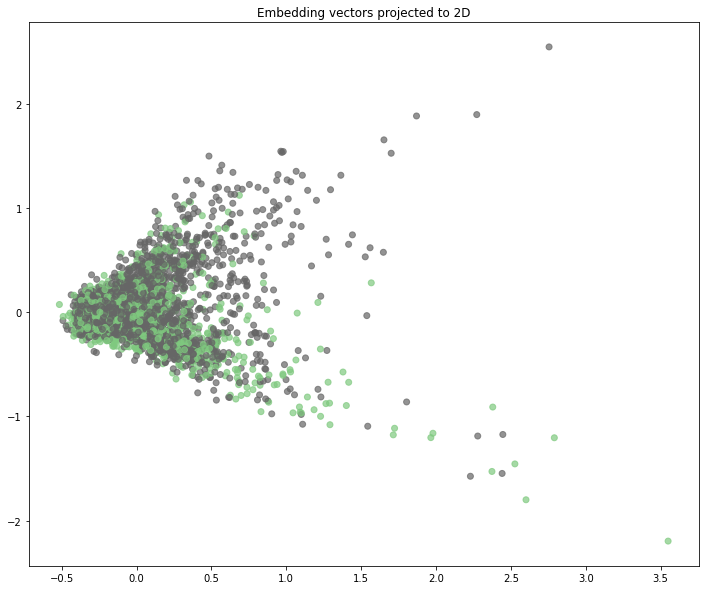

In [41]:
#project z to the 2D with PCA and plot with Pyplot
def plot_embedding(embedding, input_data):

    pca = PCA(n_components = 2)
    embedding_2d = pca.fit_transform(embedding)

    label_map = {l: i for i, l in enumerate(np.unique(input_data.y.cpu().numpy()))}
    node_colours = [label_map[target] for target in input_data.y.cpu().numpy()]

    plt.figure(figsize=(12, 10))
    plt.scatter(
        embedding_2d[:, 0],
        embedding_2d[:, 1],
        c = node_colours,
        cmap = 'Accent',
        alpha = 0.7,
    )
    plt.title('Embedding vectors projected to 2D')
    plt.savefig('embeddings.png')
    plt.show()

plot_embedding(embedding, n2v_input_data)

### **Classifiers**

**ClfDataset is not conceptually different from the InputDataset**. The only differences are: it creates split into train, test and validation and doesn't have embedding dimension parameter, but has the number of classes, preset for the binary classification. This could have been easily implemented just inside the InputDataset class, but the decision to implement separate dataset class has been taken for the sake of better code readability.

In [42]:
class ClfDataset(InMemoryDataset):

    def __init__(self, 
                 x: torch.Tensor, 
                 y: torch.Tensor, 
                 edge_index: torch.Tensor,
                 G: nx.classes.graph.Graph,
                 test_size = 0.2,
                 val_size = 0.25, 
                 transform = None):
      super(ClfDataset, self).__init__(".", transform, None, None)

      data = Data(edge_index = edge_index)

      data.x = x

      labels = y.type(torch.long)

      data.y = labels.clone().detach()

      data.num_nodes = G.number_of_nodes()

      data.num_classes = 2

      X_train, X_test, y_train, y_test = train_test_split(pd.Series(G.nodes()), 
                                                          pd.Series(y.numpy()), 
                                                          test_size = test_size, 
                                                          random_state = SEED)
      X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                        y_train, 
                                                        test_size = val_size, 
                                                        random_state = SEED)
      
      train_mask = torch.zeros(data.num_nodes, dtype = torch.bool)
      test_mask = torch.zeros(data.num_nodes, dtype = torch.bool)
      val_mask = torch.zeros(data.num_nodes, dtype = torch.bool)

      train_mask[X_train.index] = True
      test_mask[X_test.index] = True
      val_mask[X_val.index] = True

      data['train_mask'] = train_mask
      data['test_mask'] = test_mask
      data['val_mask'] = val_mask

      self.data, self.slices = self.collate([data])

The Classifier is a class that can perform **classification with SVM or MLP**, where both are imported from the `sklearn`.

Branching is provided by the `mode` parameter: `mode = 'svm'` or `mode = 'mlp'` for SVM or MLP, respectively.

The class contains three custom methods: 

1.   `validate` $-$ **grid search** on the validation dataset to find the hyperparameters,
2.   `train` $-$ sets up the found hyperparameters and **fits the classifier** of choice with the training data,
3.   `test` $-$ computes test **accuracy, precision, recall and F1-score** as well as plots the **confusion matrices**.

*NOTE:* execution of the grid search can take a while, in order to see how does it proceed, set `val_verbose` equal to `1, 2` or `3` (depending on the desired level of details).

In [43]:
class Classifier():

    def __init__(self,
                 clf_input_data,
                 clf_hparams,
                 print_data_info = False,
                 val_verbose = 0):
      super(Classifier, self).__init__()

      self.X_train = clf_input_data.x[clf_input_data['train_mask']]
      self.y_train = clf_input_data.y[clf_input_data['train_mask']]

      self.X_test = clf_input_data.x[clf_input_data['test_mask']]
      self.y_test = clf_input_data.y[clf_input_data['test_mask']]

      self.X_val = clf_input_data.x[clf_input_data['val_mask']]
      self.y_val = clf_input_data.y[clf_input_data['val_mask']]

      if print_data_info:

          print(clf_input_data)

          print("\nX_train: ", self.X_train.shape)
          print("y_train: ", self.y_train.shape)

          print("\nX_test: ", self.X_test.shape)
          print("y_test: ", self.y_test.shape)

          print("\nX_val: ", self.X_val.shape)
          print("y_val: ", self.y_val.shape)

      self.hparams = clf_hparams
      self.val_verbose = val_verbose

    def train(self, mode):

      self.validate(mode)

      if mode == 'svm':
        self.clf = svm.SVC(C = self.best_params['C'], 
                          degree = self.best_params['degree'], 
                          kernel = self.best_params['kernel'],
                          random_state = SEED)
      else:
        self.clf = MLPClassifier(hidden_layer_sizes = self.best_params['hidden_layer_sizes'], 
                        activation = self.best_params['activation'], 
                        solver = 'adam',
                        alpha = self.best_params['alpha'],
                        random_state = SEED)
          
      self.clf.fit(self.X_train, self.y_train)
      print("\nTraining has been executed successfully. Classifier: ", self.clf)

    def test(self, mode):

      print("\nChosen mode: ", mode)
      self.train(mode)

      y_pred = self.clf.predict(self.X_test)

      accuracy = accuracy_score(self.y_test, y_pred)
      precision = precision_score(self.y_test, y_pred)
      recall = recall_score(self.y_test, y_pred)
      f1 = f1_score(self.y_test, y_pred)

      print("\nTesting has been executed successfully. Results:\n")
      print("Accuracy: ", accuracy)
      print("Precision: ", precision)
      print("Recall: ", recall)
      print("F1 score: ", f1)

      print("\nConfusion matrix with and without normalization:\n")
      self.plot_confusion_matrix(mode)

      return {
          'test_accuracy': accuracy,
          'test_precision': precision,
          'test_recall': recall,
          'test_f1': f1_score
          }

    def validate(self, mode):
      
      if mode == 'svm':
        model = svm.SVC(random_state = SEED)
      else:
        model = MLPClassifier(random_state = SEED, max_iter = 10000)

      gs = GridSearchCV(model, 
                        self.hparams.grid_search_parameters, 
                        verbose = self.val_verbose)
      
      start_time = time.time()
      gs.fit(self.X_val, self.y_val)

      self.best_params = gs.best_params_
      print('\nValidation has been executed successfully. Found model parameters: ', self.best_params)
      print('Grid Search execution time is {} sec.'.format(time.time() - start_time))

    def plot_confusion_matrix(self, mode):
      
      f, axes = plt.subplots(1, 2, figsize=(10, 5), sharey = 'row')

      disp_norm = ConfusionMatrixDisplay.from_estimator(self.clf, 
                                                  self.X_test, 
                                                  self.y_test,
                                                  display_labels = self.clf.classes_,
                                                  normalize = 'all',
                                                  ax = axes[0],
                                                  colorbar = True
                                                  )
      disp_norm.ax_.set_title("Normalized")

      disp = ConfusionMatrixDisplay.from_estimator(self.clf, 
                                                    self.X_test, 
                                                    self.y_test,
                                                    display_labels = self.clf.classes_,
                                                    ax = axes[1],
                                                    colorbar = True)

      disp.ax_.set_title("Not normalized")

      plt.subplots_adjust(wspace = 0.3)
      plt.savefig(f'confusion_{mode}.png')
      plt.show()


**Dashboard** to control model training and all the pipeline of SVM training.

Currently set up hyperparameters correspond to the reported ones.

Data(edge_index=[2, 10000], x=[4263, 64], y=[4263], num_nodes=4263, num_classes=2, train_mask=[4263], test_mask=[4263], val_mask=[4263])

X_train:  torch.Size([2557, 64])
y_train:  torch.Size([2557])

X_test:  torch.Size([853, 64])
y_test:  torch.Size([853])

X_val:  torch.Size([853, 64])
y_val:  torch.Size([853])

Chosen mode:  svm

Validation has been executed successfully. Found model parameters:  {'C': 0.1, 'degree': 3, 'kernel': 'poly'}
Grid Search execution time is 54.045536518096924 sec.

Training has been executed successfully. Classifier:  SVC(C=0.1, kernel='poly', random_state=123)

Testing has been executed successfully. Results:

Accuracy:  0.6131301289566237
Precision:  0.6122931442080378
Recall:  0.9961538461538462
F1 score:  0.7584187408491948

Confusion matrix with and without normalization:



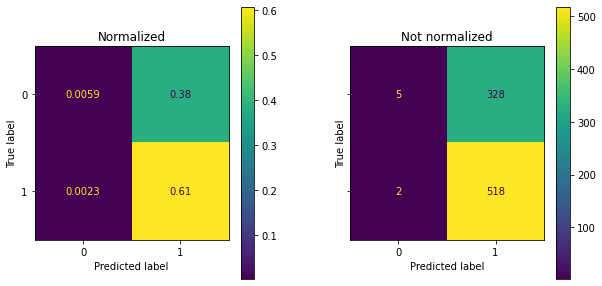

In [44]:
torch.manual_seed(SEED)
#@title SVM Hyperparameters 

class SVMClfHparams():
  #@markdown Dataset
  test_size = 0.2 #@param {type: "slider", min:0.1, max:0.3, step:0.05}
  val_size = 0.25 #@param {type: "slider", min:0.1, max:0.3, step:0.05}
  grid_search_parameters = {
    'kernel': ('linear', 'poly', 'rbf', 'sigmoid'), 
    'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 1e2],
    'degree': [2, 3, 4, 5]
              }
svm_clf_hparams = SVMClfHparams()

svm_clf_input_dataset = ClfDataset(z.detach().cpu(),
                                   y,
                                   edge_index,
                                   G,
                                   test_size = svm_clf_hparams.test_size,
                                   val_size = svm_clf_hparams.val_size)
svm_clf_input_data = svm_clf_input_dataset[0]


svm_clf = Classifier(svm_clf_input_data,
                     svm_clf_hparams,
                     print_data_info = True,
                     val_verbose = 0)

svm_test_logs = svm_clf.test('svm')

**Dashboard** to control model training and all the pipeline of MLP training.

Currently set up hyperparameters correspond to the reported ones.

Data(edge_index=[2, 10000], x=[4263, 64], y=[4263], num_nodes=4263, num_classes=2, train_mask=[4263], test_mask=[4263], val_mask=[4263])

X_train:  torch.Size([2557, 64])
y_train:  torch.Size([2557])

X_test:  torch.Size([853, 64])
y_test:  torch.Size([853])

X_val:  torch.Size([853, 64])
y_val:  torch.Size([853])

Chosen mode:  mlp

Validation has been executed successfully. Found model parameters:  {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (8, 8)}
Grid Search execution time is 591.5096306800842 sec.

Training has been executed successfully. Classifier:  MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(8, 8),
              random_state=123)

Testing has been executed successfully. Results:

Accuracy:  0.5826494724501758
Precision:  0.6168091168091168
Recall:  0.8326923076923077
F1 score:  0.7086743044189853

Confusion matrix with and without normalization:



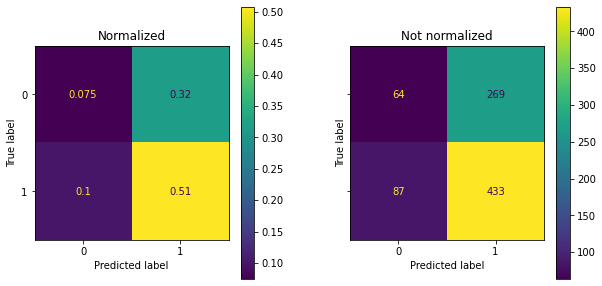

In [45]:
torch.manual_seed(SEED)
#@title MLP Hyperparameters 

class MLPClfHparams():
  #@markdown Dataset
  test_size = 0.2 #@param {type: "slider", min:0.1, max:0.3, step:0.05}
  val_size = 0.25 #@param {type: "slider", min:0.1, max:0.3, step:0.05}
  grid_search_parameters = {
    'hidden_layer_sizes': [(8, 8), (16, 16), (32, 32), (64, 64)],
    'activation': ('logistic', 'tanh', 'relu'),
    'alpha': [1e-5, 1e-4, 1e-3]
    }
mlp_clf_hparams = MLPClfHparams()

mlp_clf_input_dataset = ClfDataset(z.detach().cpu(),
                                   y,
                                   edge_index,
                                   G,
                                   test_size = mlp_clf_hparams.test_size,
                                   val_size = mlp_clf_hparams.val_size)
mlp_clf_input_data = mlp_clf_input_dataset[0]


mlp_clf = Classifier(mlp_clf_input_data,
                     mlp_clf_hparams,
                     print_data_info = True,
                     val_verbose = 0)

mlp_test_logs = mlp_clf.test('mlp')

## **Approach 2 (Graph Neural Network)**

Custom class to create **GCN model with 3 GCNConv layers**, ReLU activation and dropout support.

*NOTE:* `edge_weight` parameter has been set equal to `None` during all the executions and is only needed to provide the correct execution of the GNNExplainer.

In [46]:
class GCN(nn.Module):

    def __init__(self,
                 gcn_num_features: int,
                 gcn_hparams):
      super(GCN, self).__init__()

      self.conv1 = GCNConv(gcn_num_features, gcn_hparams.hidden_dim, normalize = False)
      self.conv2 = GCNConv(gcn_hparams.hidden_dim, gcn_hparams.hidden_dim, normalize = False)
      self.conv3 = GCNConv(gcn_hparams.hidden_dim, 2, normalize = False)

      self.p = gcn_hparams.p

    def forward(self, x, edge_index, edge_weight):

      x = F.relu(self.conv1(x, edge_index, edge_weight))
      x = F.dropout(x, self.p, training = self.training)

      x = F.relu(self.conv2(x, edge_index, edge_weight))
      x = F.dropout(x, self.p, training = self.training)

      x = self.conv3(x, edge_index, edge_weight)

      return F.log_softmax(x, dim = 1)

Custom GCN model trainer with `train` and `test` methods, which **monitor, compute and collect the history **of all the results of interest.

1.   `train` output $-$ dictionary of **loss, accuracy, precision, recall** and **F1-score histories**, collected over epochs, and train **predictions**,
2.   `test` output $-$ dictionary of **accuracy, precision, recall** and **F1-score histories**, collected over epochs, test **logits** and **predictions**.



In [47]:
class GCNTrainer():

    def __init__(self,
                 model: nn.Module,
                 optimizer: torch.optim,
                 epochs = 100):
      super(GCNTrainer, self).__init__()

      self.model = model
      self.optimizer = optimizer
      self.epochs = epochs

    def train(self,
              gcn_input_data: torch_geometric.data.data.Data,
              test_fn: Callable = None,
              verbose = True,
              print_interval: int = 10):
      
        train_loss = []

        train_accuracy = []
        train_precision = []
        train_recall = []
        train_f1 = []

        for epoch in tqdm(range(1, self.epochs + 1)):

            self.model.train()
            train_mask = gcn_input_data.train_mask

            self.optimizer.zero_grad()

            epoch_loss = F.nll_loss(self.model(gcn_input_data.x, 
                                               gcn_input_data.edge_index, 
                                               None)[train_mask], 
                                    gcn_input_data.y[train_mask])

            epoch_loss.backward()

            self.optimizer.step()

            train_loss.append(epoch_loss.item())
            train_score, _, train_pred = test_fn(self.model, gcn_input_data, 'train_mask', 'cpu', False)
            train_accuracy.append(train_score['Accuracy'])
            train_precision.append(train_score['Precision'])
            train_recall.append(train_score['Recall'])
            train_f1.append(train_score['F1'])

            if (verbose and epoch % print_interval == 0) or (epoch == self.epochs):

              print(f'  Epoch {epoch:3d} => Loss: {epoch_loss}')
              for (key, value) in train_score.items():
                  print(f'    {key}: {value:0.6f}')


        return {
              'train_loss': train_loss,
              'train_accuracy': train_accuracy,
              'train_precision': train_precision,
              'train_recall': train_recall,
              'train_f1': train_f1
              }, train_pred

    def test(self,
             gcn_input_data: torch_geometric.data.data.Data,
             plot_confusion: bool,
             test_fn: Callable = None):

        test_score, logits, test_pred = test_fn(self.model, 
                                                gcn_input_data, 
                                                'test_mask', 
                                                'cpu', 
                                                plot_confusion)

        return {
              'test_accuracy': test_score['Accuracy'],
              'test_precision': test_score['Precision'],
              'test_recall': test_score['Recall'],
              'test_f1': test_score['F1']
              }, logits, test_pred 

In [48]:
#is exploited as Callable inside test methof in the trainer class
@torch.no_grad()
def gcn_test(model: nn.Module, 
             gcn_input_data,
             mask = 'test_mask', 
             device = 'cpu',
             plot_confusion = False):

    model.eval()

    logits = model(gcn_input_data.x, 
                   gcn_input_data.edge_index, 
                   None)

    mask = gcn_input_data[mask]
    pred = logits[mask].max(1)[1]

    accuracy = pred.eq(gcn_input_data.y[mask]).sum().item() / mask.sum().item()

    y = gcn_input_data.y[mask].to(device)
    pred = pred.to(device)

    precision = precision_score(y, pred, zero_division = 0)
    recall = recall_score(y, pred)
    f1 = f1_score(y, pred)

    if plot_confusion:
        plot_confusion_matrix(y, pred)

    return {
          'Accuracy': accuracy,
          'Precision': precision,
          'Recall': recall,
          'F1': f1
          }, logits, pred

In [49]:
def plot_confusion_matrix(y, pred):
      
      f, axes = plt.subplots(1, 2, figsize=(10, 5), sharey = 'row')

      disp_norm = ConfusionMatrixDisplay.from_predictions(y,
                                                          pred,
                                                          normalize = 'all',
                                                          ax = axes[0],
                                                          colorbar = True
                                                          )
      disp_norm.ax_.set_title("Normalized")

      disp = ConfusionMatrixDisplay.from_predictions(y,
                                                     pred,
                                                     ax = axes[1],
                                                     colorbar = True)

      disp.ax_.set_title("Not normalized")

      plt.subplots_adjust(wspace = 0.3)
      plt.savefig('confusion_gcn.png')
      plt.show()

**Dashboard** to control model training and all the pipeline of GCN training.

Currently set up hyperparameters correspond to the reported ones.

In [50]:
torch.manual_seed(SEED)

#@title GCN Hyperparameters 

class GCNHparams():
  #@markdown Dataset
  test_size = 0.2 #@param {type: "slider", min:0.1, max:0.5, step:0.1}
  #@markdown Model
  hidden_dim = 16 #@param {type:"integer"}
  p = 0.2 #@param {type:"slider", min:0, max:1, step:0.05}
  #@markdown Optimizer
  lr = 0.0001 #@param {type:"number"}
  #@markdown Trainer
  epochs = 1000 #@param {type:"slider", min:100, max:1000, step:100}
  print_interval = 100 #@param {type:"slider", min:10, max:100, step:10}

gcn_hparams = GCNHparams()

gcn_input_dataset = InputDataset(
    feature_vectors, 
    y, 
    edge_index, 
    G,  
    test_size = gcn_hparams.test_size
    )

gcn_input_data = gcn_input_dataset[0]
gcn_input_data = gcn_input_data.to(device)

gcn = GCN(
    gcn_input_data.num_features,
    gcn_hparams
    ).to(device)


gcn_optimizer = torch.optim.Adam(
    list(gcn.parameters()), 
    lr = gcn_hparams.lr)


gcn_trainer = GCNTrainer(
    gcn,
    gcn_optimizer,
    epochs = gcn_hparams.epochs
)

#set up printing interval of interest or verbose = False
gcn_train_history, gcn_train_pred = gcn_trainer.train(
    gcn_input_data,
    test_fn = gcn_test,
    verbose = True,
    print_interval = gcn_hparams.print_interval
)
#hist_list.append(gcn_train_history)

  0%|          | 0/1000 [00:00<?, ?it/s]

  Epoch 100 => Loss: 26.25101661682129
    Accuracy: 0.532258
    Precision: 0.613657
    Recall: 0.650167
    F1: 0.631384
  Epoch 200 => Loss: 38.87862014770508
    Accuracy: 0.558065
    Precision: 0.616016
    Recall: 0.750595
    F1: 0.676679
  Epoch 300 => Loss: 24.536846160888672
    Accuracy: 0.568622
    Precision: 0.618332
    Recall: 0.783436
    F1: 0.691161
  Epoch 400 => Loss: 23.115524291992188
    Accuracy: 0.572141
    Precision: 0.618625
    Recall: 0.796763
    F1: 0.696484
  Epoch 500 => Loss: 16.8813419342041
    Accuracy: 0.579179
    Precision: 0.620303
    Recall: 0.817230
    F1: 0.705278
  Epoch 600 => Loss: 16.251766204833984
    Accuracy: 0.580645
    Precision: 0.619693
    Recall: 0.826749
    F1: 0.708401
  Epoch 700 => Loss: 13.289311408996582
    Accuracy: 0.585044
    Precision: 0.620351
    Recall: 0.841504
    F1: 0.714199
  Epoch 800 => Loss: 18.41579818725586
    Accuracy: 0.587977
    Precision: 0.620582
    Recall: 0.852451
    F1: 0.718267
  Epo


Training Results:

Accuracy:  0.589149560117302
Precision:  0.6199451679232351
Recall:  0.8610185625892433
F1 score:  0.7208607292289301

Testing Results:

Accuracy:  0.5814771395076201
Precision:  0.6105834464043419
Recall:  0.8653846153846154
F1 score:  0.7159904534606204

Confusion matrix with and without normalization:



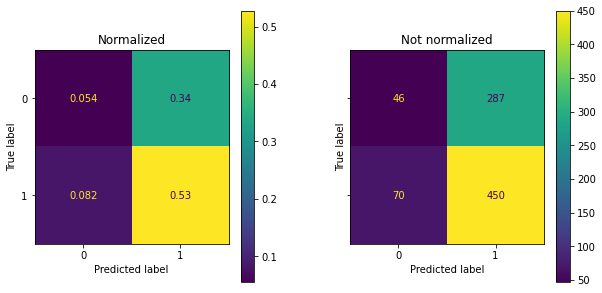

In [51]:
torch.manual_seed(SEED)

#only the last results in the history
print("\nTraining Results:\n")
print("Accuracy: ", gcn_train_history['train_accuracy'][-1])
print("Precision: ", gcn_train_history['train_precision'][-1])
print("Recall: ", gcn_train_history['train_recall'][-1])
print("F1 score: ", gcn_train_history['train_f1'][-1])

gcn_test_score, _, _ = gcn_trainer.test(
    gcn_input_data,
    plot_confusion = False,
    test_fn = gcn_test
)

print("\nTesting Results:\n")
print("Accuracy: ", gcn_test_score['test_accuracy'])
print("Precision: ", gcn_test_score['test_precision'])
print("Recall: ", gcn_test_score['test_recall'])
print("F1 score: ", gcn_test_score['test_f1'])

print("\nConfusion matrix with and without normalization:\n")
gcn_test_score, gcn_logits, gcn_test_pred = gcn_trainer.test(gcn_input_data, 
                                                             plot_confusion = True, 
                                                             test_fn = gcn_test)

# **Explainability**

In [52]:
# this is why saving logits was implemented in the test method of the trainer class
pred = gcn_logits.max(1)[1]

In [53]:
def plot_node_info(node_idx):

    print("Information about the node:\n")
    print("Name: ", list(word_index.keys())[list(word_index.values()).index(node_idx)])
    print("Index: ", node_idx)
    print("Predicted class: ", pred[node_idx].item())
    print("True class: ", gcn_input_data.y[node_idx].item())
    print("\n")

Information about the node:

Name:  PBLD
Index:  8
Predicted class:  0
True class:  1




Explain node 8: 100%|██████████| 1000/1000 [00:01<00:00, 508.38it/s]


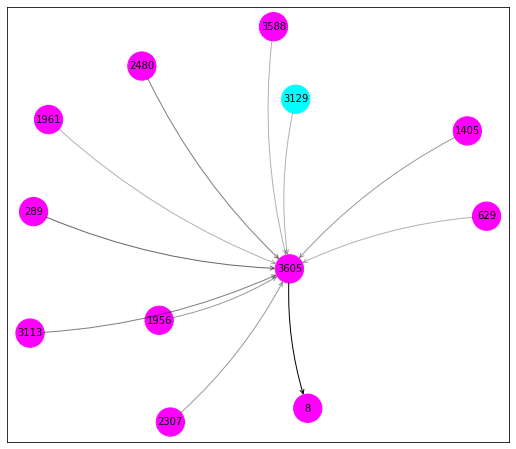

In [54]:
np.random.seed(SEED)

#different approaches to find the node of interest could be used
#for alternative one of sG nodes can be extracted for explanation
node_idx = list(pred).index(0)
plot_node_info(node_idx)

edge_masks = []
N = 10 #number of runs for the edge mask averaging

for i in range(N):
    explainer = GNNExplainer(gcn_trainer.model, 
                             epochs = gcn_hparams.epochs, 
                             return_type = 'log_prob',
                             num_hops = 2)
    
    node_feat_mask, edge_mask = explainer.explain_node(node_idx, 
                                                  gcn_input_data.x, 
                                                  gcn_input_data.edge_index, 
                                                  edge_weight = None)
    edge_masks.append(edge_mask)

avg_edge_mask = torch.mean(torch.stack(edge_masks), dim = 0)

print("\n")
rcParams['figure.figsize'] = 9, 8
ax, G = explainer.visualize_subgraph(node_idx, 
                                     gcn_input_data.edge_index,
                                     edge_mask = avg_edge_mask,
                                     y = gcn_input_data.y,
                                     seed = SEED,
                                     threshold = None)
plt.savefig(f"explain_node_{node_idx}.png", format = "PNG")

Please, **refer to the report for the detailed information** about the reasoning behind the choices.

*NOTE:* Thank you for attention! :)